# Identification of selective sweeps

## Setup

In [8]:
.libPaths('../renv/library/R-3.6/x86_64-conda-linux-gnu/')

In [9]:
# Load require packages
library(tidyverse)
library(data.table)
library(bedtoolsr)

In [10]:
# Prefix for results
results_prefix <- '/scratch/projects/trifolium/gwsd/results/'

### Functions

In [11]:
# Function to load windowd thetas 
load_windowed_thetas <- function(path){
    habitat <- str_extract(basename(path), '(?<=allSites_)(\\w+)(?=_windowed)')

    df <- suppressMessages(read_delim(path, delim = '\t')) %>%
        rename(region = 1) %>% 
        mutate(tp_scaled = tP / nSites,
               habitat = habitat) %>%
        dplyr::select(-tF, -tH, -tL, -fuf, -fud, -fayh, -zeng, -tW, -tP, -starts_with('#'))
    return(df)
}

# Function to load windowed Fst
load_windowed_fst <- function(path){
    chrom <- str_extract(basename(path), '^(.+)(?=_allSites)')
    hab_comb <- str_extract(basename(path), '(?<=allSites_)(\\w+_\\w+)(?=_windowed)')
    
    colnames <- c('region', 'Chr', 'WinCenter', 'nSites_fst', 'fst')
    df <- suppressMessages(read_delim(path, delim = '\t', skip = 1, col_names = colnames)) %>%
        
        # Set negative Fst values to 0
        mutate(fst = ifelse(fst < 0, 0, fst))
    
    return(df)
}

#' Filter dataframe to only include markers in window
#'
#' @param window_start Start position of window
#' @param window_size Size of window in bp
#' @param step Number of base pairs to shift window
#' @param df Dataframe with markers 
#'
#' @return Filtered dataframe containing only markers in windows'
get_windows <- function(window_start, window_size, df){

    df_filt <- df %>%
        arrange(pos) %>%
        filter(pos >= window_start & pos < window_start + window_size) %>%

        # Get min, max, and mid position of window
        mutate(min_pos = window_start,
               max_pos = window_start + window_size,
               mid_pos = window_start + (max_pos - min_pos) / 2)
    return(df_filt)
}

#' Calculate mean cM of markers in window
#' 
#' @param chrom_name Character vector with name of chromosome
#' @param window_size Size of window in bp
#' @param step Number of base pairs to shift window
#' @param df Dataframe with windowed markers
#'
#' @return Dataframe with mean cM in windows
calculate_windowed_means <- function(df, window_size, step, stat, thresh){

    all_pos <- seq(from = min(df$pos), to = max(df$pos), by = step)
    df_withWindows <- purrr::map_dfr(all_pos, get_windows,
                                   df = df,
                                   window_size = window_size,
                                   .id = 'win_id')
    
    df_winMeans <- df_withWindows %>%
        group_by(Chr, win_id, min_pos, max_pos, mid_pos) %>%
        summarise(mean = mean(!!sym(stat)),
                  max = max(!!sym(stat)),
                  min = min(!!sym(stat)),
                  num_gt_thresh = sum(!!sym(stat) > thresh),
                  num_lt_thresh = sum(!!sym(stat) < -thresh),
                  gt_frat = sum(num_gt_thresh) / n(),
                  lt_frat = sum(num_lt_thresh) / n())
    return(df_winMeans)
}

# Function to find outliers. 
find_outliers <- function(df){
    
    # Identify cutoffs of empirical distributions used for definigin outliers
    fst_quant_filt <- quantile(df %>% pull(fst), probs = c(0.99))
    tp_quant_filt <- quantile(df %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
    td_quant_filt <- quantile(df %>% pull(delta_td_ur), probs = c(0.01, 0.99))
    
    outlier_df <- df %>%
    mutate(fst_outlier = ifelse(fst >= fst_quant_filt, 1, 0),
           tp_outlier = ifelse(delta_tp_ur <= tp_quant_filt[1] | delta_tp_ur >= tp_quant_filt[2], 1, 0),
           td_outlier = ifelse(delta_td_ur <= td_quant_filt[1] | delta_td_ur >= td_quant_filt[2], 1, 0),
           all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0))
    
    return(outlier_df)
}

load_xpnsl_norm <- function(path, type){
    
    if(type == 'raw'){
        col_names <- TRUE
    }else{
        col_names <- c('start', 'end', 'num_scores', 'frac_gt', 'frac_lt', 'gt_thresh', 'lt_thresh', 'max', 'min')
    }
    chrom_name <- str_extract(basename(path), pattern = '.+(?=_Urban)')
    df <- suppressMessages(read_delim(path, delim = '\t', col_names = col_names)) %>% 
        mutate(Chr = chrom_name)
    return(df)
    
}

mark_xpnsl_outliers <- function(df_raw_scores, outlier_windows){
    
    gt_windows <- outlier_windows %>% filter(gt_thresh == 1)
    lt_windows <- outlier_windows %>% filter(lt_thresh == 1)

    gt_range <- data.table(start = gt_windows$start, end = gt_windows$end)
    lt_range <- data.table(start = lt_windows$start, end = lt_windows$end)
    
    gt_filt <- setDT(df_raw_scores)[pos %inrange% gt_range]
    lt_filt <- setDT(df_raw_scores)[pos %inrange% lt_range]
    
    df_raw_scores_mod <- df_raw_scores %>% 
        mutate(outlier_cat = case_when(pos %in% gt_filt$pos ~ 'Urban sel',
                                       pos %in% lt_filt$pos ~ 'Rural sel',
                                       TRUE ~ 'Not outlier'))
    
    return(df_raw_scores_mod)
}

## SFS-based tests

- I estimated $\theta_{\pi}$, Tajima's D, and $F_{ST}$ in 5 Kb non-overlapping windows across the genome
- For each window, I will estimate the difference in $\theta_{\pi}$ and Tajima's D between urban and rural habitats (i.e., $\Delta\theta_{\pi}$ and $\Delta$Td)
- I'll define outlier regions as those with:
    1. Lower/Higher $\Delta\theta_{\pi}$ than the genome-wide average (top 1%)
    2. Lower/Higher $\Delta$Td than the genome-wide average (top 1%)
    3. Higher $F_{ST}$ than the genome-wide average (top 1%)

In [12]:
# Load Fst
fst_path <- paste0(results_prefix, 'angsd/summary_stats/hudson_fst/byHabitat/allSites')
fst_df <- list.files(fst_path, recursive = TRUE, full.names = TRUE, pattern = '.+_allSites_Urban_Rural_windowed.fst') %>%
    purrr::map_dfr(., load_windowed_fst) %>% 
    mutate(region = str_extract(region, pattern = '(?<=\\()\\d+,\\d+(?=\\)$)')) %>% 
    separate(region, into = c('start', 'end'), sep = ',') %>% 
    mutate(chrom_pos = paste0(Chr, '_', WinCenter))

In [13]:
# Load summary stats (i.e., pi and Tajima's D)
# Currently ignores suburban habitats
thetas_path <- paste0(results_prefix, 'angsd/summary_stats/thetas/byHabitat/allSites')
thetas_df <- list.files(thetas_path, recursive = TRUE, pattern = '.+_allSites_(Rural|Urban)_windowedThetas.gz.pestPG', full.names = TRUE) %>%
    purrr::map_dfr(., load_windowed_thetas) %>% 
    mutate(region = str_extract(region, pattern = '(?<=\\()\\d+,\\d+(?=\\)$)')) %>% 
    separate(region, into = c('start', 'end'), sep = ',') %>% 
    mutate(chrom_pos = paste0(Chr, '_', WinCenter))

In [14]:
# Convert to wide format for calculating habitat differences, etc
thetas_df_wide <- thetas_df %>% 
    pivot_wider(values_from = c('Tajima', 'nSites', 'tp_scaled'), names_from = 'habitat')

In [15]:
# Combine windowed theta and fst estimates into single df
# Calculate difference in pi and Tajima's D
total_windows_theta <- nrow(thetas_df_wide)
total_windows_fst <- nrow(fst_df)

allStats_windowed_df <- thetas_df_wide %>%
    filter(chrom_pos %in% fst_df$chrom_pos) %>%
    left_join(., fst_df, by = c('chrom_pos', 'Chr','start', 'end', 'WinCenter')) %>%
    mutate(delta_tp_ur = tp_scaled_Urban - tp_scaled_Rural,
           delta_td_ur = Tajima_Urban - Tajima_Rural)

total_windows_allStats <- nrow(allStats_windowed_df)

print(sprintf('There are %s windows with estimates of fst and %s windows with estimates of thetas', total_windows_fst, total_windows_theta))
print(sprintf('%s windows were missing from the Fst Dataframe. %s windows remaining', total_windows_theta - total_windows_fst, total_windows_allStats))

[1] "There are 161499 windows with estimates of fst and 178473 windows with estimates of thetas"
[1] "16974 windows were missing from the Fst Dataframe. 161499 windows remaining"


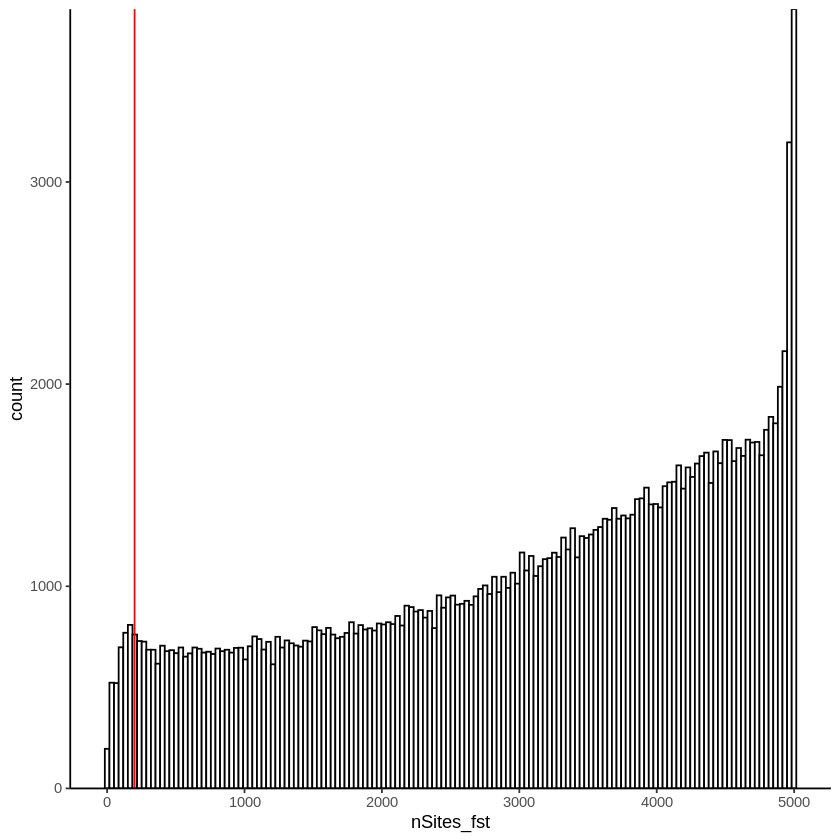

In [16]:
# What does the distribution of the number of sites per window look like?
# Keep windows with at least 200 sites. 
allStats_windowed_df %>% 
    ggplot(., aes(x = nSites_fst)) +
    geom_histogram(bins = 150, color = 'black', fill = 'white') +
    geom_vline(xintercept = 200, color = 'red') +
    scale_y_continuous(expand = c(0, 0)) +
    theme_classic()

In [17]:
# Identify outliers across genome
nSites_thresh <- 200
allStats_windowed_filt <- allStats_windowed_df %>%
    filter_at(vars(starts_with('nSites')), ~ . >= nSites_thresh)

fst_quant_filt <- quantile(allStats_windowed_filt %>% pull(fst), probs = c(0.99))
tp_quant_filt <- quantile(allStats_windowed_filt %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
td_quant_filt <- quantile(allStats_windowed_filt %>% pull(delta_td_ur), probs = c(0.01, 0.99))

fst_vals <- allStats_windowed_filt %>% pull(fst)
num_sites <- nrow(fst_quant_filt)

allStats_windowed_filt <- allStats_windowed_filt %>%
    mutate(fst_outlier = ifelse(fst >= fst_quant_filt, 1, 0),
           tp_outlier = ifelse(delta_tp_ur <= tp_quant_filt[1] | delta_tp_ur >= tp_quant_filt[2], 1, 0),
           td_outlier = ifelse(delta_td_ur <= td_quant_filt[1] | delta_td_ur >= td_quant_filt[2], 1, 0),
           all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0)) %>%
    dplyr::select(chrom_pos, Chr, start, end, WinCenter, fst, delta_tp_ur, delta_td_ur, contains('_outlier'))

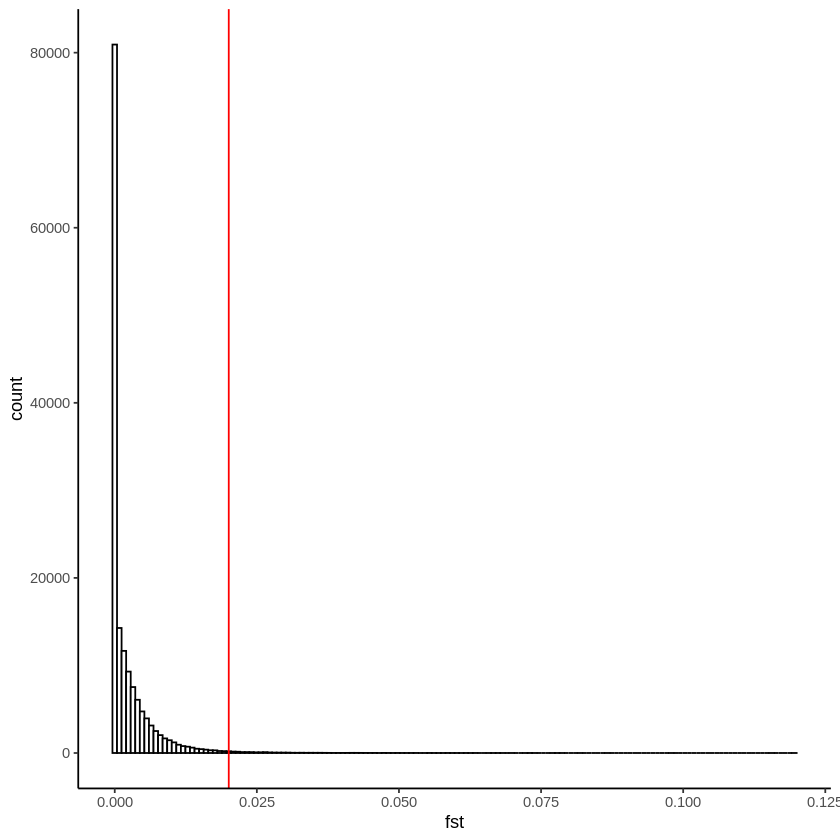

In [18]:
allStats_windowed_filt %>% 
    ggplot(., aes(x = fst)) +
    geom_histogram(bins = 150, color = 'black', fill = 'white') +
#     scale_y_continuous(expand = c(0, 0)) +
    geom_vline(xintercept = fst_quant_filt[1], color = 'red') +
    theme_classic()

In [19]:
allStats_windowed_filt %>% 
    group_by(fst_outlier, tp_outlier, td_outlier) %>%
    summarise(n = n())

`summarise()` has grouped output by 'fst_outlier', 'tp_outlier'. You can override using the `.groups` argument.


fst_outlier,tp_outlier,td_outlier,n
<dbl>,<dbl>,<dbl>,<int>
0,0,0,151045
0,0,1,2045
0,1,0,2268
0,1,1,665
1,0,0,1077
1,0,1,280
1,1,0,57
1,1,1,162


In [20]:
allStats_windowed_filt %>% 
    filter(all_outlier == 1) %>%
    mutate(direction = ifelse(delta_tp_ur < 0 & delta_td_ur < 0, 'Urban lower', 'Rural lower')) %>%
    group_by(direction) %>%
    summarise(n = n())

direction,n
<chr>,<int>
Rural lower,89
Urban lower,73


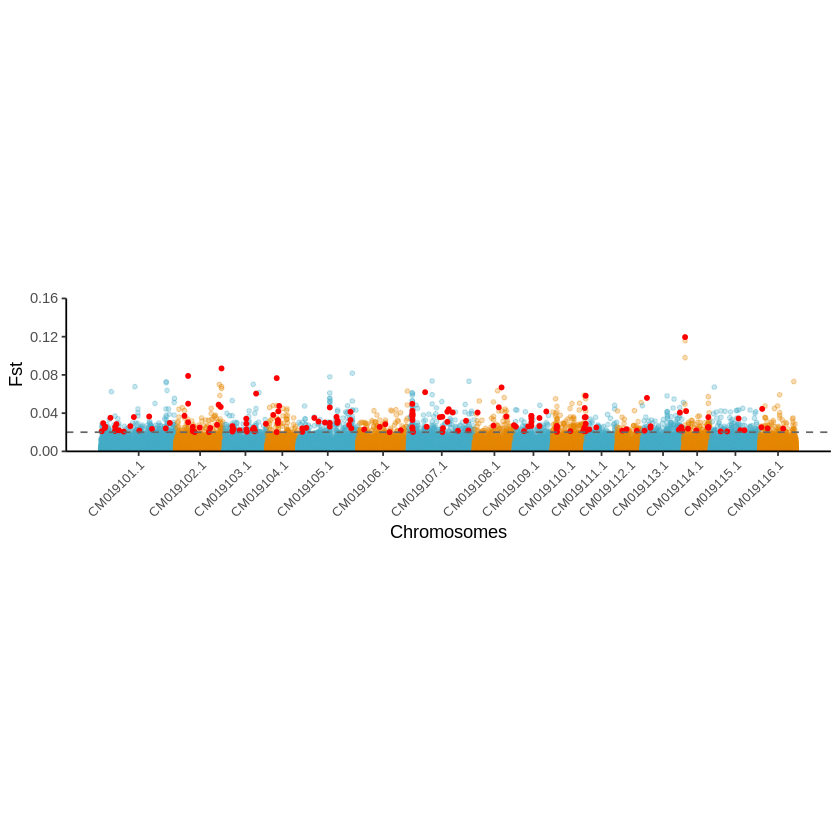

In [21]:
data_cum <- allStats_windowed_filt %>% 
    group_by(Chr) %>% 
    summarise(max_WinCenter = max(WinCenter)) %>% 
    mutate(WinCenter_add = lag(cumsum(max_WinCenter), default = 0)) %>% 
    dplyr::select(Chr, WinCenter_add)

allStats_windowed_filt_mod <- allStats_windowed_filt %>%
    inner_join(data_cum, by = "Chr") %>% 
    mutate(WinCenter_cum = WinCenter + WinCenter_add) 

axis_set <- allStats_windowed_filt_mod %>% 
  group_by(Chr) %>% 
  summarize(center = mean(WinCenter_cum))

outliers <- allStats_windowed_filt_mod %>% filter(all_outlier == 1)

manhat_plot <- allStats_windowed_filt_mod %>%
    mutate(chrom_cat = case_when(Chr == 'CM019101.1' ~ 'One',
                                 Chr == 'CM019102.1' ~ 'Two',
                                 Chr == 'CM019103.1' ~ 'One',
                                 Chr == 'CM019104.1' ~ 'Two',
                                 Chr == 'CM019105.1' ~ 'One',
                                 Chr == 'CM019106.1' ~ 'Two',
                                 Chr == 'CM019107.1' ~ 'One',
                                 Chr == 'CM019108.1' ~ 'Two',
                                 Chr == 'CM019109.1' ~ 'One',
                                 Chr == 'CM019110.1' ~ 'Two',
                                 Chr == 'CM019111.1' ~ 'One',
                                 Chr == 'CM019112.1' ~ 'Two',
                                 Chr == 'CM019113.1' ~ 'One',
                                 Chr == 'CM019114.1' ~ 'Two',
                                 Chr == 'CM019115.1' ~ 'One',
                                 Chr == 'CM019116.1' ~ 'Two')) %>%
    filter(all_outlier != 1) %>% 
    ggplot(aes(x = WinCenter_cum, y = fst)) +
        geom_point(shape = 21, alpha = 0.3, size = 1, aes(fill = chrom_cat, color = chrom_cat)) +
        geom_point(data = outliers, shape = 21, alpha = 1, size = 1, color = 'red', fill = 'red') +
        geom_hline(yintercept = fst_quant_filt, color = "grey40", linetype = "dashed") +
        scale_x_continuous(label = axis_set$Chr, breaks = axis_set$center) +
        scale_y_continuous(expand = c(0,0)) +
        coord_cartesian(ylim = c(0, 0.16)) +
        scale_fill_manual(values = c("#46ACC8", "#E58601")) + 
        scale_color_manual(values = c("#46ACC8", "#E58601")) + 
        ylab('Fst') + xlab('Chromosomes') +
        theme_classic() +
        theme(
            aspect.ratio = 0.2,
            legend.position = "none",
            panel.border = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank(),
            axis.text.x = element_text(angle = 45, size = 8,hjust = 1)
          )
manhat_plot

In [22]:
allStats_windowed_filt_mod %>% filter(all_outlier == 1) %>% nrow() / allStats_windowed_filt_mod %>% nrow()

[1] 0.001027925

## XP-nSL

- XP-nSL is a haplotype-based scan for selective sweeps
- I estimated XP-nSL in 50 Kb non-overlapping windows across the genome
- For each window I estimated the min and max normalized XP-nSL score, and the proportion of sites where normalized |XP-nSL| > 2
- Windows are marked as outliers if they fall in the top 1% of windows based on the proportion of outlier sites

In [23]:
xpnsl_path <- '../../results/sweeps/xpnsl/'
pattern <- '.+_Urban_Rural.xpnsl.out.norm$'
xpnsl_raw_df <- list.files(xpnsl_path, recursive = TRUE, full = TRUE, pattern = pattern) %>% 
    map_dfr(., load_xpnsl_norm, type = 'raw') %>% 
    rename('normxpnsl' = 'normxpehh') %>% 
    dplyr::select(-id)

In [24]:
head(xpnsl_raw_df)

pos,gpos,p1,sL1,p2,sL2,xpnsl,normxpnsl,crit,Chr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
60409,17,0.768293,6.02195,0.7317070,6.14672,-0.00890653,-0.161338,0,CM019101.1
60426,18,0.256098,5.04439,0.1829270,5.73724,-0.05589440,-0.960627,0,CM019101.1
60431,19,0.182927,5.48507,0.1219510,6.08599,-0.04514880,-0.777839,0,CM019101.1
60443,20,0.000000,6.06068,0.0243902,6.36889,-0.02154270,-0.376287,0,CM019101.1
60463,21,0.170732,5.58482,0.0853659,6.29027,-0.05165990,-0.888596,0,CM019101.1
60479,22,0.817073,6.41365,0.7804880,6.18646,0.01566300,0.256603,0,CM019101.1


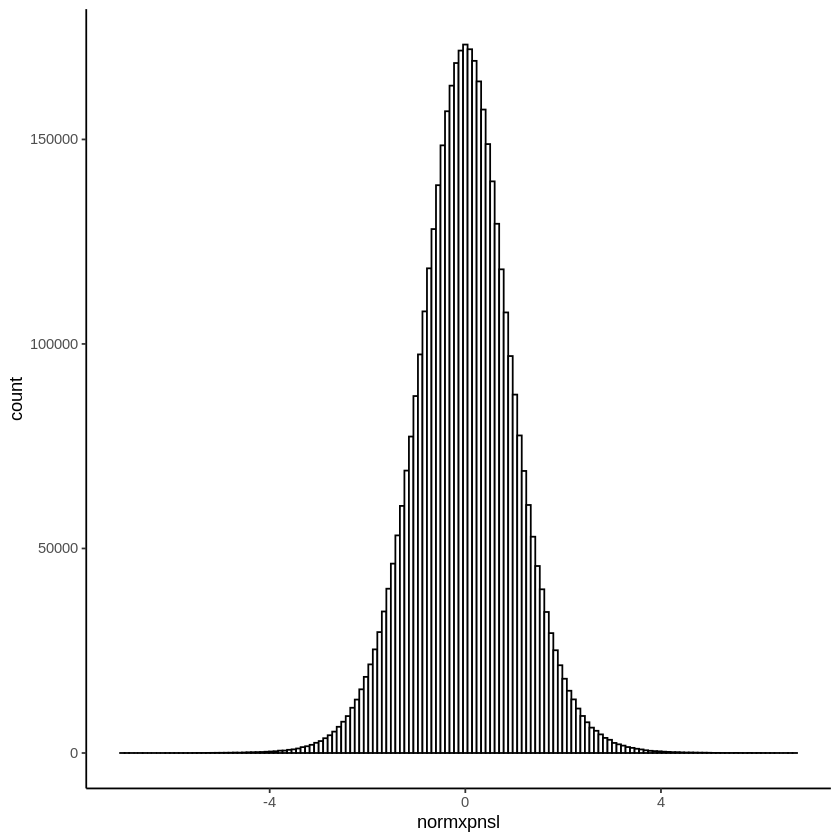

In [25]:
ggplot(xpnsl_raw_df, aes(x = normxpnsl)) +
    geom_histogram(bins = 150, color = 'black', fill = 'white') +
    theme_classic()

In [26]:
pattern <- '.+_Urban_Rural.xpnsl.out.norm\\..+'
winSize <- 50000
xpnsl_win_df_selscan <- list.files(xpnsl_path, recursive = TRUE, full = TRUE, pattern = pattern) %>% 
    map_dfr(., load_xpnsl_norm, type = 'win') %>% 
    mutate(WinCenter = (start + (winSize / 2)))

In [27]:
xpnsl_outlier_windows <- xpnsl_win_df_selscan %>% filter(gt_thresh == 1 | lt_thresh == 1)

In [28]:
# How many windows 
nrow(xpnsl_outlier_windows)

[1] 359

In [29]:
nrow(xpnsl_outlier_windows %>% filter(gt_thresh == 1)) / nrow(xpnsl_win_df_selscan)

[1] 0.01009082

In [30]:
df_raw_scores_mod <- xpnsl_raw_df %>% 
    group_split(Chr) %>% 
    purrr::map_dfr(., mark_xpnsl_outliers, outlier_windows = xpnsl_outlier_windows)

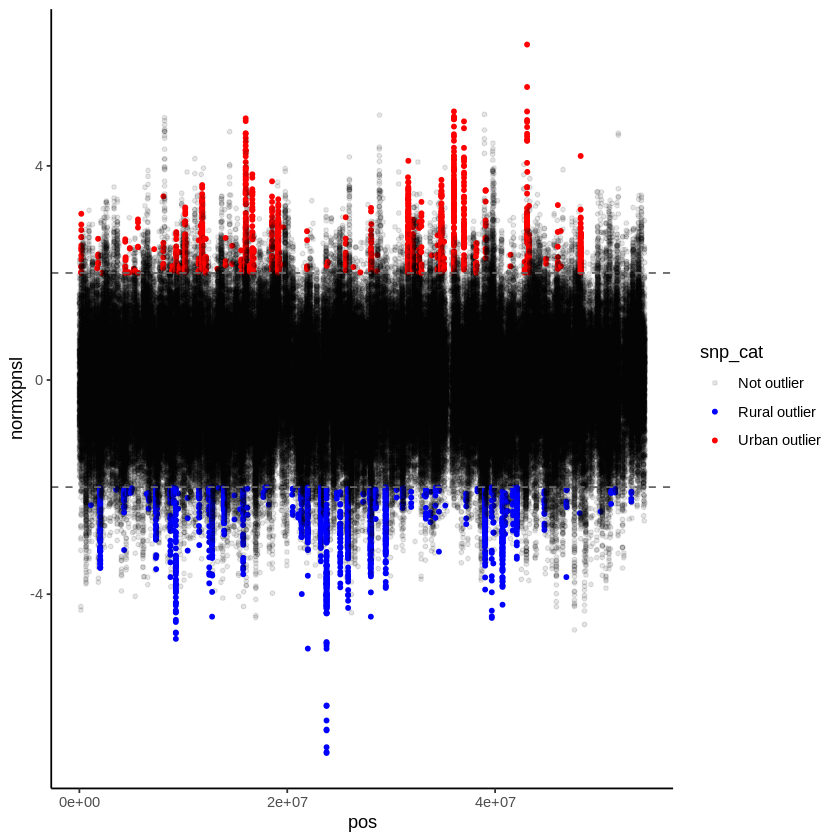

In [31]:
df_raw_scores_mod %>% 
    filter(Chr == 'CM019103.1') %>% 
    mutate(snp_cat = case_when(outlier_cat == 'Urban sel' & crit == 1 ~ 'Urban outlier',
                               outlier_cat == 'Rural sel' & crit == -1 ~ 'Rural outlier',
                               TRUE ~ 'Not outlier')) %>% 
    ggplot(., aes(x = pos, y = normxpnsl)) +
        geom_point(shape = 21, size = 1, aes(alpha = snp_cat, color = snp_cat, fill = snp_cat)) +
        geom_hline(yintercept = 2, color = "grey40", linetype = "dashed") +
        geom_hline(yintercept = -2, color = "grey40", linetype = "dashed") +
        scale_fill_manual(values = c('black', 'blue', 'red')) + 
        scale_color_manual(values = c('black','blue', 'red')) + 
        scale_alpha_manual(values = c(0.1, 1, 1)) +
    theme_classic()

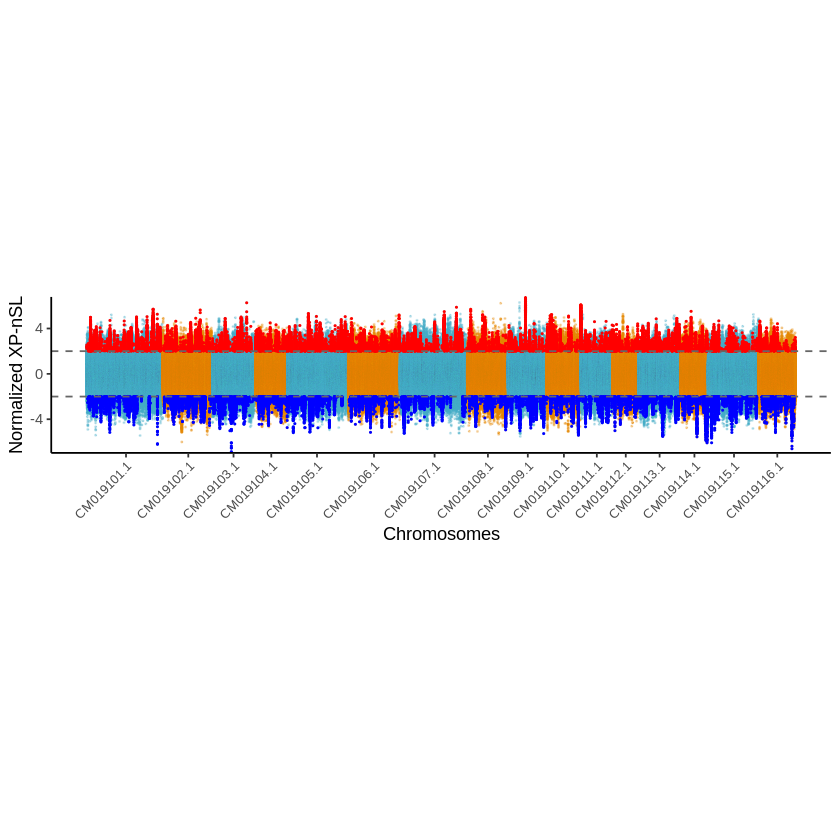

In [32]:
# Manhattan plot with raw XP-nSL scores
# Outliers SNPs in outlier windows colored Red or Blue
# Should probably plot windowed stats instead. This is a bit much
data_cum <- df_raw_scores_mod %>% 
    group_by(Chr) %>% 
    summarise(max_pos = max(pos)) %>% 
    mutate(pos_add = lag(cumsum(max_pos), default = 0)) %>% 
    dplyr::select(Chr, pos_add)

df_raw_scores_mod2 <- df_raw_scores_mod %>%
    inner_join(data_cum, by = "Chr") %>% 
    mutate(pos_cum = pos + pos_add) 

axis_set <- df_raw_scores_mod2 %>% 
  group_by(Chr) %>% 
  summarize(center = mean(pos_cum))

urban_outliers <- df_raw_scores_mod2 %>% filter(outlier_cat == 'Urban sel' & crit == 1)
rural_outliers <- df_raw_scores_mod2 %>% filter(outlier_cat == 'Rural sel' & crit == -1)

df_raw_scores_mod2 %>%
    mutate(chrom_cat = case_when(Chr == 'CM019101.1' ~ 'One',
                                 Chr == 'CM019102.1' ~ 'Two',
                                 Chr == 'CM019103.1' ~ 'One',
                                 Chr == 'CM019104.1' ~ 'Two',
                                 Chr == 'CM019105.1' ~ 'One',
                                 Chr == 'CM019106.1' ~ 'Two',
                                 Chr == 'CM019107.1' ~ 'One',
                                 Chr == 'CM019108.1' ~ 'Two',
                                 Chr == 'CM019109.1' ~ 'One',
                                 Chr == 'CM019110.1' ~ 'Two',
                                 Chr == 'CM019111.1' ~ 'One',
                                 Chr == 'CM019112.1' ~ 'Two',
                                 Chr == 'CM019113.1' ~ 'One',
                                 Chr == 'CM019114.1' ~ 'Two',
                                 Chr == 'CM019115.1' ~ 'One',
                                 Chr == 'CM019116.1' ~ 'Two')) %>%
    ggplot(aes(x = pos_cum, y = normxpnsl)) +
        geom_point(shape = 21, alpha = 0.3, size = 0.2, aes(fill = chrom_cat, color = chrom_cat)) +
        geom_point(data = urban_outliers, shape = 21, alpha = 1, size = 0.2, fill = 'red', color = 'red') +
        geom_point(data = rural_outliers, shape = 21, alpha = 1, size = 0.2, fill = 'blue', color = 'blue') +
        geom_hline(yintercept = 2, color = "grey40", linetype = "dashed") +
        geom_hline(yintercept = -2, color = "grey40", linetype = "dashed") +
        scale_x_continuous(label = axis_set$Chr, breaks = axis_set$center) +
        scale_y_continuous(expand = c(0,0)) +
        scale_fill_manual(values = c("#46ACC8", "#E58601")) + 
        scale_color_manual(values = c("#46ACC8", "#E58601")) + 
        ylab('Normalized XP-nSL') + xlab('Chromosomes') +
        theme_classic() +
        theme(
            aspect.ratio = 0.2,
            legend.position = "none",
            panel.border = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank(),
            axis.text.x = element_text(angle = 45, size = 8,hjust = 1)
          )

Warning message:
“Removed 267 rows containing missing values (geom_point).”

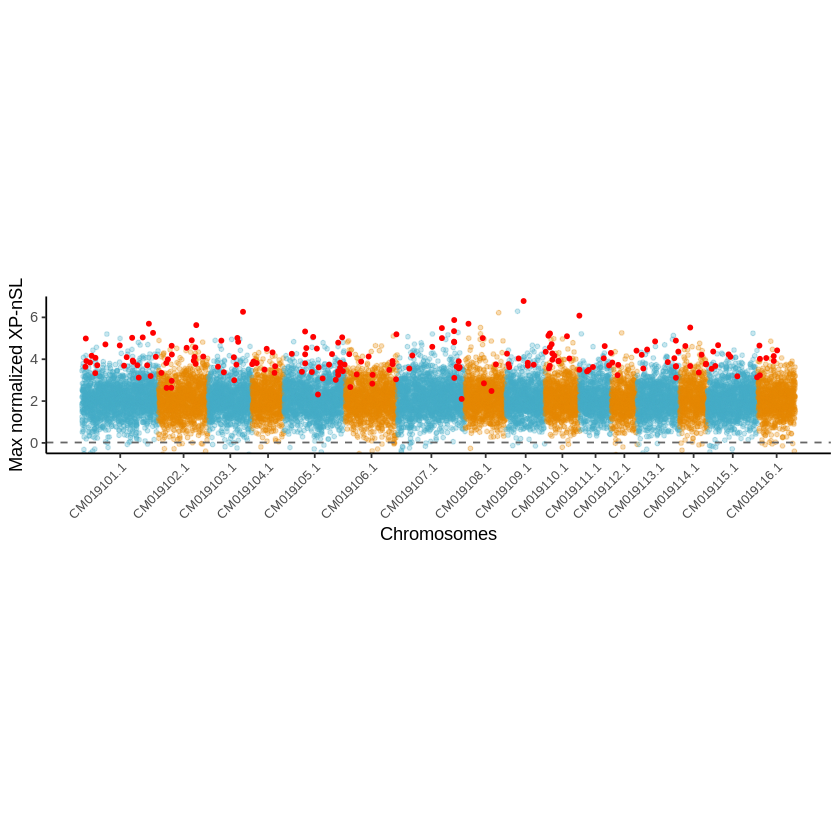

In [33]:
data_cum <- xpnsl_win_df_selscan %>% 
    group_by(Chr) %>% 
    summarise(max_WinCenter = max(WinCenter)) %>% 
    mutate(WinCenter_add = lag(cumsum(max_WinCenter), default = 0)) %>% 
    dplyr::select(Chr, WinCenter_add)

xpnsl_win_df_selscan_mod <- xpnsl_win_df_selscan %>%
    inner_join(data_cum, by = "Chr") %>% 
    mutate(WinCenter_cum = WinCenter + WinCenter_add) 

axis_set <- xpnsl_win_df_selscan_mod %>% 
  group_by(Chr) %>% 
  summarize(center = mean(WinCenter_cum))

urban_outliers <- xpnsl_win_df_selscan_mod %>% filter(gt_thresh == 1)

manhat_plot <- xpnsl_win_df_selscan_mod %>%
    mutate(chrom_cat = case_when(Chr == 'CM019101.1' ~ 'One',
                                 Chr == 'CM019102.1' ~ 'Two',
                                 Chr == 'CM019103.1' ~ 'One',
                                 Chr == 'CM019104.1' ~ 'Two',
                                 Chr == 'CM019105.1' ~ 'One',
                                 Chr == 'CM019106.1' ~ 'Two',
                                 Chr == 'CM019107.1' ~ 'One',
                                 Chr == 'CM019108.1' ~ 'Two',
                                 Chr == 'CM019109.1' ~ 'One',
                                 Chr == 'CM019110.1' ~ 'Two',
                                 Chr == 'CM019111.1' ~ 'One',
                                 Chr == 'CM019112.1' ~ 'Two',
                                 Chr == 'CM019113.1' ~ 'One',
                                 Chr == 'CM019114.1' ~ 'Two',
                                 Chr == 'CM019115.1' ~ 'One',
                                 Chr == 'CM019116.1' ~ 'Two')) %>%
    filter(gt_thresh != 1) %>% 
    ggplot(aes(x = WinCenter_cum, y = max)) +
        geom_point(shape = 21, alpha = 0.3, size = 1, aes(fill = chrom_cat, color = chrom_cat)) +
        geom_point(data = urban_outliers, shape = 21, alpha = 1, size = 1, color = 'red', fill = 'red') +
        geom_hline(yintercept = fst_quant_filt, color = "grey40", linetype = "dashed") +
        scale_x_continuous(label = axis_set$Chr, breaks = axis_set$center) +
        scale_y_continuous(expand = c(0,0)) +
        coord_cartesian(ylim = c(-0.5, 7)) +
        scale_fill_manual(values = c("#46ACC8", "#E58601")) + 
        scale_color_manual(values = c("#46ACC8", "#E58601")) + 
        ylab('Max normalized XP-nSL') + xlab('Chromosomes') +
        theme_classic() +
        theme(
            aspect.ratio = 0.2,
            legend.position = "none",
            panel.border = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank(),
            axis.text.x = element_text(angle = 45, size = 8,hjust = 1)
          )
manhat_plot

## Overlap

In [59]:
xpnsl_sel_windows <- xpnsl_win_df_selscan_mod %>% filter(gt_thresh == 1 | lt_thresh == 1) %>% 
    dplyr::select(Chr, start, end,)
fst_sel_windows <- allStats_windowed_filt_mod %>% filter(all_outlier == 1) %>% 
    dplyr::select(Chr, start, end)
print(sprintf("There are %s, outlier XP-nSL windows and %s outlier Fst/pi/Td windows", nrow(xpnsl_sel_windows), nrow(fst_sel_windows)))

[1] "There are 359, outlier XP-nSL windows and 162 outlier Fst/pi/Td windows"


In [69]:
# Get Fst windows that overlap with xpnsl windows
# Minimum fraction of 1% required for overlap to handle edge cases 
# where window was being reported twice if right at boundary of XP-nSL window
overlappingWindows_fst <- bt.intersect(fst_sel_windows, xpnsl_sel_windows, wa = T, f = 0.01)
names(overlappingWindows_fst) <- c('Chr', 'start', 'end')

In [71]:
# Get XP-nSK windows that overlap with Fst windows
# Distinct required since some windows have multipel Fst windows within them and I don't want duplicates
overlappingWindows_xpnsl <- bt.intersect(xpnsl_sel_windows, fst_sel_windows, wa = T, f = 0.01) %>% 
    distinct()
names(overlappingWindows_xpnsl) <- c('Chr', 'start', 'end')
overlappingWindows_xpnsl

Chr,start,end
<fct>,<int>,<int>
CM019101.1,5600001,5650001
CM019101.1,12150001,12200001
CM019102.1,15950001,16000001
CM019102.1,21900001,21950001
CM019103.1,28000001,28050001
CM019103.1,39000001,39050001
CM019103.1,40700001,40750001
CM019105.1,21050001,21100001
CM019105.1,26350001,26400001


In [73]:
overlappingWindows_xpnsl_counts <- bt.intersect(xpnsl_sel_windows, fst_sel_windows, c = T, f = 0.01) %>% 
    filter(V4 > 0)
names(overlappingWindows_xpnsl_counts) <- c('Chr', 'start', 'end', 'num_fst_windows')
overlappingWindows_xpnsl_counts

Chr,start,end,num_fst_windows
<fct>,<int>,<int>,<int>
CM019101.1,5600001,5650001,1
CM019101.1,12150001,12200001,1
CM019102.1,15950001,16000001,2
CM019102.1,21900001,21950001,2
CM019103.1,28000001,28050001,1
CM019103.1,39000001,39050001,1
CM019103.1,40700001,40750001,1
CM019105.1,21050001,21100001,1
CM019105.1,26350001,26400001,1


In [74]:
nrow(overlappingWindows_fst) / nrow(fst_sel_windows)

[1] 0.2469136

In [81]:
gff <- ape::read.gff('../resources/TrR.v5.renamed_reformated.gtf.gz', GFF3 = TRUE) %>% 
    dplyr::select(seqid, start, end, everything())

In [86]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
bt.intersect(gff, overlappingWindows_xpnsl, wb = T) %>% 
    filter(V5 == 'transcript')

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
<fct>,<int>,<int>,<fct>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>,<int>,<int>
CM019101.1,5600001,5600580,AUGUSTUS,transcript,NA,-,NA,ID=CM019101.1.jg723.t1;function=far upstream element-binding protein 1-like [Cicer arietinum];accessionXP_004498916.1,CM019101.1,5600001,5650001
CM019101.1,5602108,5603047,AUGUSTUS,transcript,NA,+,NA,"ID=CM019101.1.jg724.t1;function=ubiquitin-protein ligase, putative [Medicago truncatula];accessionAES59262.2",CM019101.1,5600001,5650001
CM019101.1,5605468,5607036,AUGUSTUS,transcript,NA,+,NA,"ID=CM019101.1.jg725.t1;function=ubiquitin-protein ligase, putative [Medicago truncatula];accessionKEH39934.1",CM019101.1,5600001,5650001
CM019101.1,5619831,5622190,AUGUSTUS,transcript,NA,-,NA,ID=CM019101.1.jg727.t1;function=26S proteasome regulatory particle non-ATPase subunit 12 [Medicago truncatula];accessionAES59289.1,CM019101.1,5600001,5650001
CM019101.1,5627667,5631146,AUGUSTUS,transcript,NA,+,NA,ID=CM019101.1.jg729.t1;function=hypothetical protein TSUD_06410 [Trifolium subterraneum];accessionGAU26969.1,CM019101.1,5600001,5650001
CM019101.1,5641096,5645082,AUGUSTUS,transcript,NA,+,NA,ID=CM019101.1.jg730.t1;function=protein NDL2 [Cicer arietinum];accessionXP_004498913.1,CM019101.1,5600001,5650001
CM019101.1,12154049,12159245,AUGUSTUS,transcript,NA,-,NA,ID=CM019101.1.jg1662.t1;function=vacuolar sorting receptor [Medicago truncatula];accessionAES79849.1,CM019101.1,12150001,12200001
CM019101.1,12162189,12162962,AUGUSTUS,transcript,NA,+,NA,ID=CM019101.1.jg1663.t1;function=70 kDa peptidyl-prolyl isomerase [Trifolium pratense];accessionPNY16802.1,CM019101.1,12150001,12200001
CM019101.1,12196958,12200001,AUGUSTUS,transcript,NA,+,NA,"ID=CM019101.1.jg1669.t1;function=putative Ulp1 protease family catalytic domain, putative transposase, Ptta/En/Spm, plant [Medicago truncatula];accessionRHN51483.1",CM019101.1,12150001,12200001


## Playing around

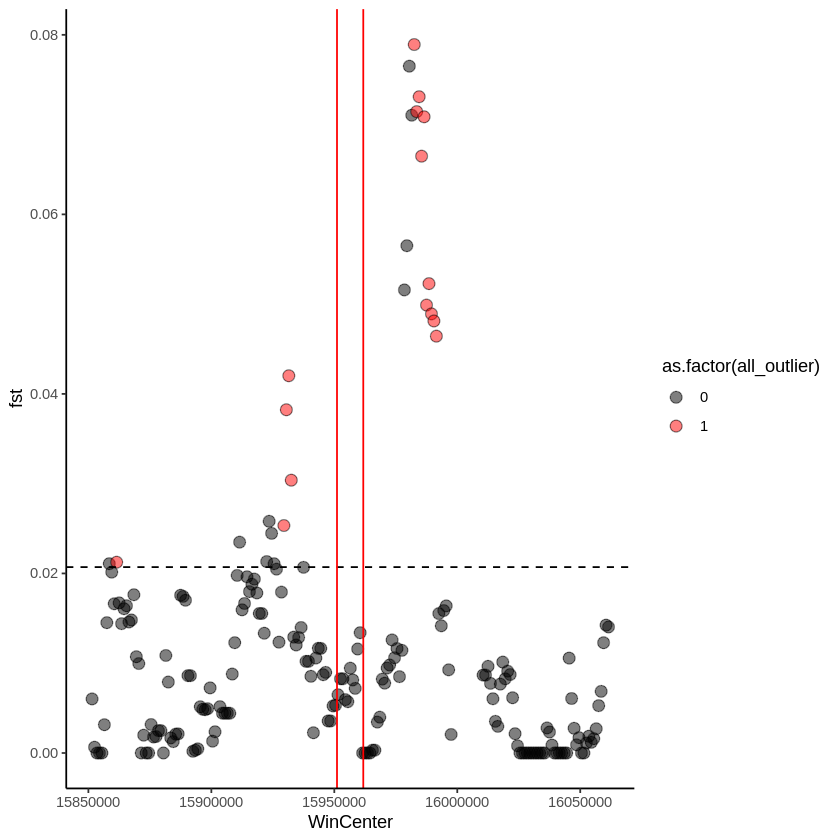

In [22]:
fst_quant <- quantile(testChr_allStats %>% pull(fst), probs = c(0.99))
tp_quant <- quantile(testChr_allStats %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
td_quant <- quantile(testChr_allStats %>% pull(delta_td_ur), probs = c(0.01, 0.99))
Ac_outlier_df <- testChr_allStats %>%
    filter(WinCenter >= 15951095 - 100000 & WinCenter <= 15961779 + 100000) %>%
    mutate(fst_outlier = ifelse(fst >= fst_quant, 1, 0),
           tp_outlier = ifelse(delta_tp_ur <= tp_quant[1] | delta_tp_ur >= tp_quant[2], 1, 0),
           td_outlier = ifelse(delta_td_ur <= td_quant[1] | delta_td_ur >= td_quant[2], 1, 0),
           all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0))
Ac_outlier_df %>%
    ggplot(., aes(x = WinCenter, y = fst)) +
        geom_point(size = 3, alpha = 0.5, shape = 21, aes(fill = as.factor(all_outlier))) +
        geom_hline(yintercept = fst_quant, color = 'black', size = 0.5, linetype = 'dashed') +
        scale_fill_manual(values = c('black', 'red')) +
        geom_vline(xintercept = 15951095, color = 'red') +
        geom_vline(xintercept = 15961779, color = 'red') + 
        theme_classic()